# A simple optimization problem: NoTransport model


In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport import ForcingParameter, ForcingUnit, KernelParameter
from seapopym.model import NoTransportModel

from seapopym_optimization.algorithm.genetic_algorithm.factory import GeneticAlgorithmFactory
from seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm import GeneticAlgorithmParameters
from seapopym_optimization.algorithm.genetic_algorithm.logbook import OptimizationLog
from seapopym_optimization.configuration_generator.no_transport_configuration_generator import (
    NoTransportConfigurationGenerator,
)
from seapopym_optimization.cost_function import TimeSeriesScoreProcessor
from seapopym_optimization.cost_function.cost_function import CostFunction
from seapopym_optimization.cost_function.metric import rmse_comparator
from seapopym_optimization.functional_group import NoTransportFunctionalGroup, Parameter
from seapopym_optimization.functional_group.base_functional_group import FunctionalGroupSet
from seapopym_optimization.functional_group.parameter_initialization import random_uniform_exclusive
from seapopym_optimization.observations.observation import DayCycle
from seapopym_optimization.observations.time_serie import TimeSeriesObservation


In [2]:
logging.basicConfig(level=logging.INFO, format="\n%(asctime)s - %(name)s - %(levelname)s - %(message)s")
logger = logging.getLogger("seapopym_optimization")
logger.setLevel(logging.INFO)

In [3]:
client = Client()
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50042,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:50054,Total threads: 3
Dashboard: http://127.0.0.1:50058/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:50045,


## 1. Generate synthetic forcing data


In [4]:
nb_days_by_year = 365
nb_years = 20

# Temperature: sinusoidal pattern
temperature = xr.DataArray(
    data=(np.sin(np.linspace(0, (2 * np.pi) * nb_years, nb_days_by_year * nb_years)) * 5 + 20).reshape(
        (nb_days_by_year * nb_years, 1, 1, 1)
    ),
    dims=["time", "latitude", "longitude", "depth"],
    coords={
        "time": pd.date_range("2023-01-01", periods=nb_days_by_year * nb_years, freq="D"),
        "latitude": [0],
        "longitude": [0],
        "depth": [0],
    },
    name="temperature",
    attrs={
        "units": "Celsius",
        "long_name": "Sea surface temperature",
        "standard_name": "sea_surface_temperature",
    },
)

# Primary production: random + cosine pattern
primary_production = xr.DataArray(
    data=(
        (
            np.random.rand(nb_days_by_year * nb_years).reshape((nb_days_by_year * nb_years, 1, 1))
            + (np.cos(np.linspace(0, np.pi * nb_years, nb_days_by_year * nb_years))).reshape(
                (nb_days_by_year * nb_years, 1, 1)
            )
        )
        + 2
    )
    / 100,
    dims=["time", "latitude", "longitude"],
    coords={
        "time": pd.date_range("2023-01-01", periods=nb_days_by_year * nb_years, freq="D"),
        "latitude": [0],
        "longitude": [0],
    },
    name="primary_production",
    attrs={
        "units": "kg/m^2/day",
        "long_name": "Primary production",
        "standard_name": "primary_production",
    },
)

# Set axis attributes
temperature.time.attrs = {"axis": "T"}
primary_production.time.attrs = {"axis": "T"}
temperature.latitude.attrs = {"axis": "Y"}
primary_production.latitude.attrs = {"axis": "Y"}
temperature.longitude.attrs = {"axis": "X", "unit": "degrees_east"}
primary_production.longitude.attrs = {"axis": "X"}
temperature.depth.attrs = {"axis": "Z"}

forcing_parameter = ForcingParameter(
    temperature=ForcingUnit(forcing=temperature),
    primary_production=ForcingUnit(forcing=primary_production),
)


2025-10-01 08:08:57,605 - seapopym.configuration.no_transport.forcing_parameter - INFO - Standardizing coordinates: {'time': 'T', 'latitude': 'Y', 'longitude': 'X', 'depth': 'Z'}

2025-10-01 08:08:57,614 - seapopym.configuration.no_transport.forcing_parameter - INFO - Standardizing coordinates: {'time': 'T', 'latitude': 'Y', 'longitude': 'X'}


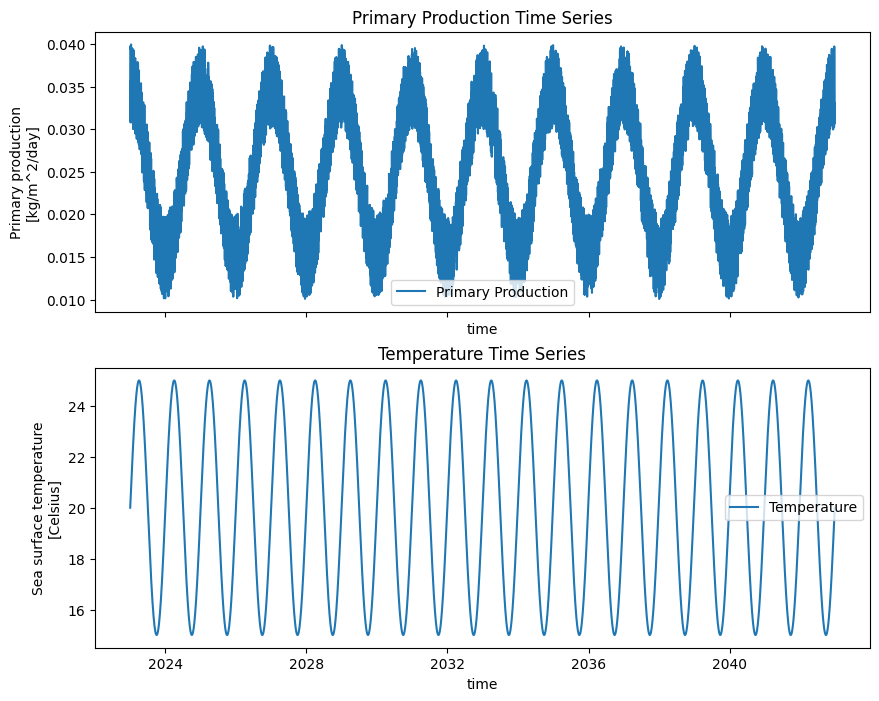

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
primary_production.plot(label="Primary Production", ax=ax1)
ax1.legend()
ax1.set_title("Primary Production Time Series")
temperature.plot(label="Temperature", ax=ax2)
ax2.legend()
ax2.set_title("Temperature Time Series")
plt.show()

## 2. Generate synthetic observations


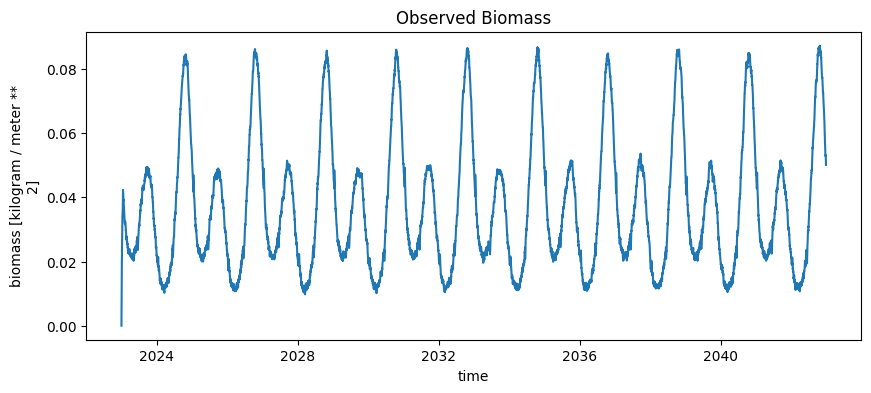

In [6]:
# Create a configuration generator
configuration_generator = NoTransportConfigurationGenerator()

# Run a model with known parameters to generate synthetic observations
initial_config = configuration_generator.generate(
    functional_group_parameters=[
        NoTransportFunctionalGroup(
            name="Zooplankton",
            day_layer=0,
            night_layer=0,
            energy_transfert=0.1668,
            gamma_tr=-0.11,
            tr_0=10.38,
            gamma_lambda_temperature=0.15,
            lambda_temperature_0=1 / 150,
        )
    ],
    forcing_parameters=forcing_parameter,
    kernel=KernelParameter(),
)

with NoTransportModel.from_configuration(initial_config) as initial_model:
    initial_model.run()
    observed_biomass = initial_model.state.biomass

# Prepare observation data
observed_biomass = observed_biomass.expand_dims({"layer": [0]}).isel(functional_group=0).drop_vars(["functional_group"])
observed_biomass.layer.attrs = {"axis": "Z"}

plt.figure(figsize=(10, 4))
observed_biomass.plot()
plt.title("Observed Biomass")

# Create observation object
observation = TimeSeriesObservation(
    name="Zooplankton Biomass", observation=observed_biomass, observation_type=DayCycle.DAY
)

## 3. Define functional groups for optimization


In [7]:
epsilon = np.finfo(float).eps
functional_groups = [
    NoTransportFunctionalGroup(
        name="Zooplankton",
        day_layer=0,
        night_layer=0,
        energy_transfert=Parameter("D1N1_energy_transfert", epsilon, 0.5, init_method=random_uniform_exclusive),
        gamma_tr=Parameter("D1N1_gamma_tr", -0.3, -epsilon, init_method=random_uniform_exclusive),
        tr_0=Parameter("D1N1_tr_0", epsilon, 100, init_method=random_uniform_exclusive),
        gamma_lambda_temperature=Parameter(
            "D1N1_gamma_lambda_temperature", epsilon, 1 / 4, init_method=random_uniform_exclusive
        ),
        lambda_temperature_0=Parameter("D1N1_lambda_temperature_0", epsilon, 0.3, init_method=random_uniform_exclusive),
    ),
]

fg_set = FunctionalGroupSet(functional_groups=functional_groups)

## 4. Create cost function with processor


In [8]:
# Create processor with RMSE metric
processor = TimeSeriesScoreProcessor(comparator=rmse_comparator)

# Create cost function
cost_function = CostFunction(
    configuration_generator=configuration_generator,
    functional_groups=fg_set,
    forcing=forcing_parameter,
    kernel=KernelParameter(),
    observations=[observation],
    processor=processor,
)

## 5. Initialize logbook with Sobol samples


In [9]:
logbook = OptimizationLog.from_sobol_samples(fg_set, sample_number=32, fitness_names=["Zooplankton Biomass"])

## 6. Configure and run genetic algorithm


In [10]:
metaparam = GeneticAlgorithmParameters(
    ETA=20,
    INDPB=0.2,
    CXPB=0.7,
    MUTPB=1,
    NGEN=10,
    POP_SIZE=200,
    cost_function_weight=(-1,),  # Minimize RMSE
)

In [11]:
genetic_algorithm = GeneticAlgorithmFactory.create_distributed(
    meta_parameter=metaparam,
    cost_function=cost_function,
    client=client,
    logbook=logbook,
)
genetic_algorithm


2025-10-01 08:09:01,299 - seapopym_optimization.algorithm.genetic_algorithm.factory - INFO - Creating genetic algorithm in distributed mode

2025-10-01 08:09:01,299 - seapopym_optimization.algorithm.genetic_algorithm.factory - INFO - Distributing forcing to Dask workers with broadcast=True...

2025-10-01 08:09:03,013 - seapopym_optimization.algorithm.genetic_algorithm.factory - INFO - Distributing observation 'Zooplankton Biomass' to Dask workers with broadcast=True...


GeneticAlgorithm(meta_parameter=GeneticAlgorithmParameters(ETA=20, INDPB=0.2, CXPB=0.7, MUTPB=1, NGEN=10, POP_SIZE=200, TOURNSIZE=3, cost_function_weight=(np.float64(-1.0),)), cost_function=CostFunction(configuration_generator=<seapopym_optimization.configuration_generator.no_transport_configuration_generator.NoTransportConfigurationGenerator object at 0x11b7240e0>, functional_groups=FunctionalGroupSet(functional_groups=[NoTransportFunctionalGroup(name='Zooplankton', day_layer=0, night_layer=0, energy_transfert=Parameter(name='D1N1_energy_transfert', lower_bound=np.float64(2.220446049250313e-16), upper_bound=0.5, init_method=<function random_uniform_exclusive at 0x11a52c0e0>), lambda_temperature_0=Parameter(name='D1N1_lambda_temperature_0', lower_bound=np.float64(2.220446049250313e-16), upper_bound=0.3, init_method=<function random_uniform_exclusive at 0x11a52c0e0>), gamma_lambda_temperature=Parameter(name='D1N1_gamma_lambda_temperature', lower_bound=np.float64(2.220446049250313e-16), 

# 7. Run optimization


In [12]:
optimization_results = genetic_algorithm.optimize()


2025-10-01 08:09:03,023 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - INFO - OptimizationLog found. Loading last generation.

2025-10-01 08:09:03,024 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - WARNING - Some individuals in the logbook have no fitness values. Re-evaluating the population.

2025-10-01 08:09:18,509 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - INFO - Generation 1 / 10.

2025-10-01 08:09:30,055 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - INFO - Generation 2 / 10.

2025-10-01 08:09:41,405 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - INFO - Generation 3 / 10.

2025-10-01 08:09:53,018 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - INFO - Generation 4 / 10.

2025-10-01 08:10:04,610 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - INFO - Generation 5 / 10.

2025-10-01 08:10:16,334 - seapopym_opti

## 8. Plot results


Extract the best individual from the logbook


In [13]:
best_idx = optimization_results.dataset["weighted_fitness"].argmax(dim=["generation", "individual"])
best_individual = optimization_results.dataset.isel(best_idx)

parameters = dict(
    zip(
        list(best_individual.parameter.data),
        list(best_individual.parameters.data),
        strict=True,
    ),
)

best_individual

<xarray.Dataset> Size: 744B
Dimensions:                      (parameter: 5, objective: 1)
Coordinates:
    individual                   int64 8B 73
  * parameter                    (parameter) <U29 580B 'D1N1_energy_transfert...
  * objective                    (objective) <U19 76B 'Zooplankton Biomass'
    generation                   int64 8B 9
Data variables:
    parameters                   (parameter) float64 40B 0.2927 ... -0.08455
    fitness                      (objective) float64 8B 0.003003
    weighted_fitness_objectives  (objective) float64 8B -0.003003
    weighted_fitness             float64 8B -0.003003
    is_from_previous             float64 8B 0.0

Compute biomass with optimized parameters


In [14]:
optimized_fg = NoTransportFunctionalGroup(
    name="Zooplankton",
    day_layer=0,
    night_layer=0,
    energy_transfert=parameters["D1N1_energy_transfert"],
    gamma_tr=parameters["D1N1_gamma_tr"],
    tr_0=parameters["D1N1_tr_0"],
    gamma_lambda_temperature=parameters["D1N1_gamma_lambda_temperature"],
    lambda_temperature_0=parameters["D1N1_lambda_temperature_0"],
)
optimized_config = configuration_generator.generate(
    functional_group_parameters=[optimized_fg],
    forcing_parameters=forcing_parameter,
    kernel=KernelParameter(),
)

with NoTransportModel.from_configuration(optimized_config) as optimized_model:
    optimized_model.run()
    simulated_biomass = optimized_model.state.biomass

# Extract biomass for first functional group
simulated_biomass = (
    simulated_biomass.expand_dims({"layer": [0]}).isel(functional_group=0).drop_vars(["functional_group"])
)
simulated_biomass.layer.attrs = {"axis": "Z"}

And plot comparison with observations


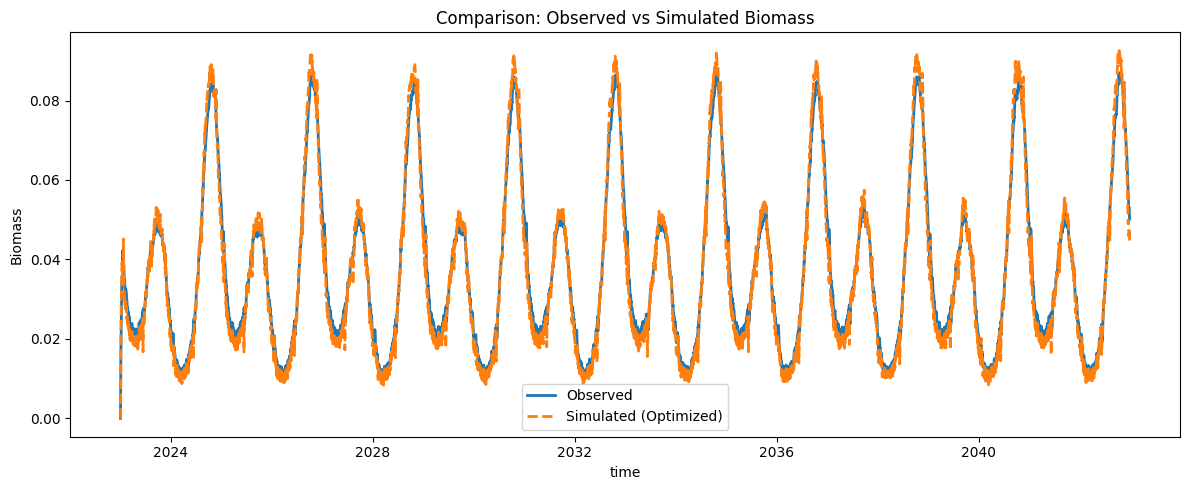

In [15]:
# Compare observed vs simulated biomass
fig, ax = plt.subplots(figsize=(12, 5))

observed_biomass.plot(label="Observed", ax=ax, linewidth=2)
simulated_biomass.plot(label="Simulated (Optimized)", ax=ax, linewidth=2, linestyle="--")

ax.set_title("Comparison: Observed vs Simulated Biomass")
ax.set_ylabel("Biomass")
ax.legend()

plt.tight_layout()
plt.show()

# Compute final RMSE
final_rmse = rmse_comparator(simulated_biomass.squeeze(), observation)